# The FeS<sub>2</sub> example

This notebook shows how the X-Ray Larch library (Larch) can be used to achieve results which are equivalent to those obtainde using Demeter (Artemis and Athena). I also illustrates how the notebook structure can be used as an alternative to publish how the processing and analysis of data are performed.

The FeS<sub>2</sub> example is well documented example and used to introduce the main features of Athena and Artemis. The example covers the basic processing and analysis of XAS data going from raw XAS data to EXAFS fit. 

The sources consulted to complete the example it is discused include the [Artemis Users’ GuideFeS2](http://bruceravel.github.io/demeter/artug/examples/fes2.html), the [2011 XAS workshop at Diamond](https://vimeo.com/340207346) and a discussion of the [fit and its model](https://speakerdeck.com/bruceravel/discussion-of-the-fes2-exafs-analysis-example). These were combined with the [Larch user guide](https://xraypy.github.io/xraylarch/).


## Preparation:

Get libraries and define functions for processing and inspection of results

In [19]:
# Larch libraries are imported for processing data 

############################################
#        functions for step 1              #
############################################

# to read from text files
from larch.io import read_ascii

############################################
#        functions for step 2              #
############################################
# Pre-edge subtraction and normalization
from larch.xafs import pre_edge

# Background subtraction
from larch.xafs import autobk

# Forward XAFS Fourier transform
from larch.xafs import xftf

# import plot labels to avoid having to type the markup
from larch.wxlib import plotlabels as plab

# import the larch.io libraries for managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup


from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline


from numpy import log
from larch.utils import group2dict, dict2group

############################################
#          Display functions               #
############################################


# the following show the contents of each group
def show_data(groups_list):
    for fe_xas in groups_list:
        print("path:\t\t", fe_xas.path)
        print("filename:\t", fe_xas.filename)
        print(fe_xas.header)
        print(fe_xas.data)
        print(fe_xas.attrs)
        print(fe_xas.array_labels)
        print('energy:', fe_xas.energy)
        print('i0:',fe_xas.i0)
        print('xmu:',fe_xas.mu)    


#calculate pre-edge and post edge and add them to group
# as with the basic workflow we want to avoid the data below E0 - 117.00

def plot_mu(groups_list, p_width=6.4, p_height=4.8, pre_edge = False, post_edge = False):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        if pre_edge:
            plt.plot(group_xas.energy, group_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        if post_edge:
            plt.plot(group_xas.energy, group_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
        plt.plot(group_xas.energy, group_xas.mu, 'b', label=group_xas.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        if pre_edge and post_edge:
            plt.title("pre-edge and post_edge fitting to $\mu$")
        else:
            plt.title("$\mu$")
        plt.legend() # show legend
        plt.show()

def plot_normalised(groups_list, p_width=6.4, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        plt.plot(group_xas.energy, group_xas.flat, label=group_xas.filename) # plot flattened and normalised energy
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel(r'normalised x$\mu$(E)') # label y axis
        plt.legend() # show legend
        plt.show()
        
def plot_mu_and_norm(groups_list, p_width=12.8, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        # first plot shows absorption with pre edge and post edge lines
        plt.subplot(1, 2, 1)
        plt.plot(group_xas.energy, group_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        plt.plot(group_xas.energy, group_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
        plt.plot(group_xas.energy, group_xas.mu, 'b', label=group_xas.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("pre-edge and post_edge fitting to $\mu$")
        plt.legend() # show legend
        # second plot shows normalised absorption
        plt.subplot(1, 2, 2)
        plt.plot(group_xas.energy, group_xas.flat, label=group_xas.filename) # plot flattened and normalised energy
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel(r'normalised x$\mu$(E)') # label y axis
        plt.legend() # show legend
        
# https://vimeo.com/340207346 40:00
# plot magnitude in r-space
def plot_in_r(groups_list, p_width=6.4, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        plt.plot(group_xas.r, group_xas.chir_mag,label=group_xas.filename)
        plt.xlabel(plab.r)
        plt.ylabel(plab.chirmag.format(3))
        plt.grid(linestyle=':', linewidth=1) #show and format grid
        plt.xlim(0,6)
        plt.legend()
    plt.show()
    
def plot_in_k(groups_list, p_width=6.4, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        plt.plot(group_xas.k, group_xas.chi*group_xas.k**2, label=group_xas.filename)
        plt.xlabel(plab.r)
        plt.ylabel(plab.chir.format(2))
        plt.title(group_xas.filename+" in k space")
        plt.grid(linestyle=':', linewidth=1) #show and format grid
        plt.xlim(0,14.5)
        plt.legend()
    plt.show()

## Define the inputs for the exercise

The files provided are saved in a folder called data

In [2]:
# reproduction needs to record these variables as "external inputs" to the code

data_location = "./data"

# XAS input file 
fes2_file = 'fes2_rt01_mar02.xmu'
data_labels = "energy mu i0"

# crystal file can be used in fitting
crystal_files = "FeS2.inp"

# Larch does not handle Artemis projects 
# For this GSD parameters and scattering 
# paths are saved to csv files.
gds_file = 'FeS2_gds.csv'
spl_file = 'FeS2_sp.csv'

### 1. Import the data file.
The "read ascii" function from larch takes the name of the file and the labels for the data columns. As the provided file contains mu, there is no need to calculate it, just need to label the data accordingly

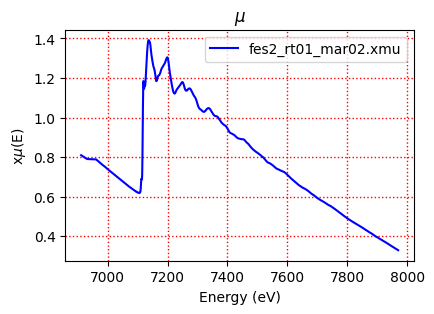

In [3]:
# fe_xas is not an input 
# it is an intermediate output from the read operation,
# its evolution is preserved into the athena project and the plots
fe_xas=[]

# read ascii files
# labels tell the reader how to name the resulting columns
# eneregy and mu are the most important labels
input_file = Path(data_location,fes2_file)
a_group = read_ascii(input_file, labels = data_labels)
fe_xas.append(a_group)

# show_data(fe_xas)
plot_mu(fe_xas,4.5,3)

### 2. Background removal and Fourier transform.
Find a set of parameters that gives a good background removal and Fourier transform. Note that the first few data points in the pre-edge are odd – be sure to select pre-edge parameters that avoid that bit of data.

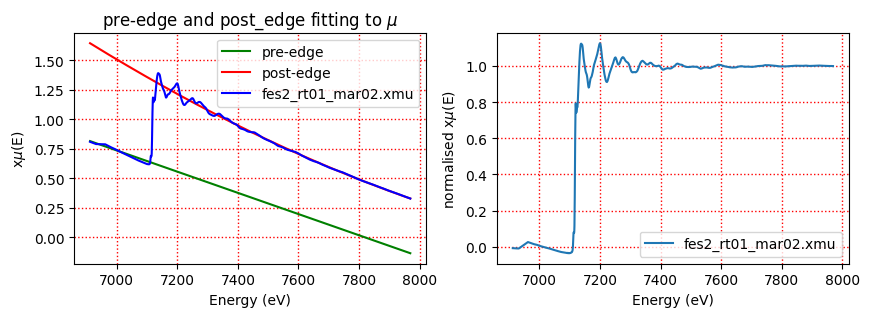

In [4]:
pre_edge(fe_xas[0], group=fe_xas[0])
plot_mu_and_norm(fe_xas,10,3)

The initial values of the data skew the pre-edge fitting and affect the normalisation. Setting the pre-edge values to exclude those initial values corrects this issue.

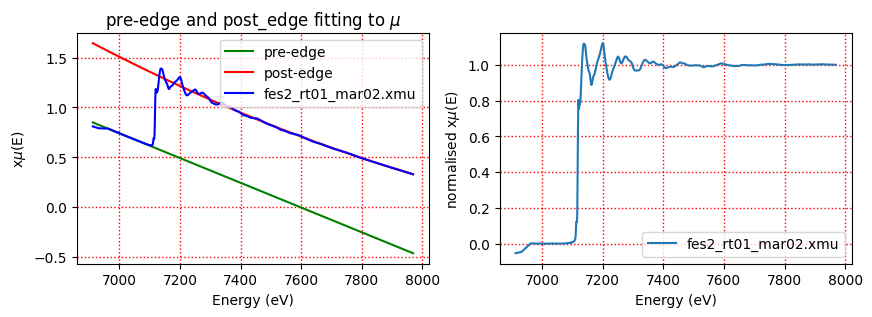

In [5]:
# normalise setting pre_edge to the same as 
for group_xas in fe_xas:
    pre_edge(group_xas, group=group_xas, pre1=-117, pre2=-30)
    
plot_mu_and_norm(fe_xas,10,3)    
#plot_mu_pre_post(fe_xas)
#plot_normalised(fe_xas)

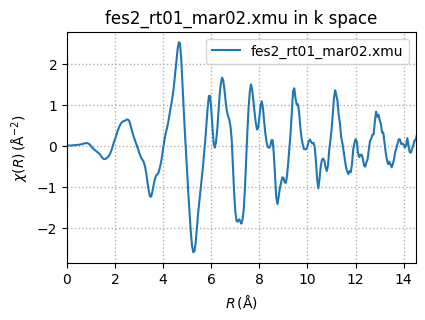

In [22]:
autobk(fe_xas[0], rbkg=1.0)
plot_in_k(fe_xas,4.5,3)

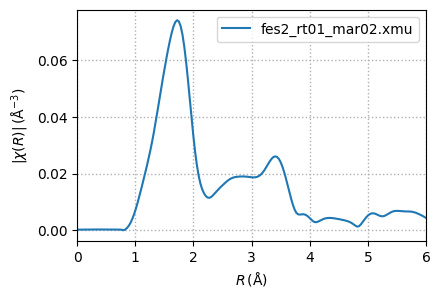

In [23]:
xftf(fe_xas[0], kweight=0.5, kmin=2.0, kmax=15, dk=4, kwindow='Hanning')
plot_in_r(fe_xas,4.5,3)

In [17]:

# save as an athena project
project_name = 'fes2_larch3.prj'
fe_project = create_athena(project_name)
for group_xas in fe_xas:
    fe_project.add_group(group_xas)
fe_project.save()
vars(fe_project)